In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
np.random.seed(0)   
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

**# Transfer Learning: p5271 #**

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[0:53199]
Y_train_SS = Y_train_SS[0:53199]
Y_train_V = Y_train_V[0:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 52989
Validation samples: 7570
Testing samples: 15140


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

Train on 52989 samples, validate on 7570 samples
Epoch 1/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0107 - dense_5_loss: 0.0072 - dense_6_loss: 0.0035

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.00811, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 8s 145us/sample - loss: 0.0106 - dense_5_loss: 0.0071 - dense_6_loss: 0.0035 - val_loss: 0.0081 - val_dense_5_loss: 0.0068 - val_dense_6_loss: 0.0013
Epoch 2/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0031 - dense_6_loss: 7.5789e-04
Epoch 2: val_loss improved from 0.00811 to 0.00696, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 116us/sample - loss: 0.0039 - dense_5_loss: 0.0031 - dense_6_loss: 7.5625e-04 - val_loss: 0.0070 - val_dense_5_loss: 0.0061 - val_dense_6_loss: 8.9019e-04
Epoch 3/100
52384/52989 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0026 - dense_6_loss: 5.9998e-04
Epoch 3: val_loss improved from 0.00696 to 0.00622, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 115us/sample - loss: 0.0032 - dense_5_loss: 0.0026 - dense_6_loss: 6.0023e-04 - val_loss: 0.0062 - val_dense_5_loss: 0.0056 - val_dense_6_loss: 6.3326e-04
Epoch 4/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0024 - dense_6_loss: 5.2799e-04
Epoch 4: val_loss improved from 0.00622 to 0.00555, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 117us/sample - loss: 0.0029 - dense_5_loss: 0.0024 - dense_6_loss: 5.2678e-04 - val_loss: 0.0056 - val_dense_5_loss: 0.0045 - val_dense_6_loss: 0.0011
Epoch 5/100
52768/52989 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0023 - dense_6_loss: 5.0021e-04
Epoch 5: val_loss improved from 0.00555 to 0.00526, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 121us/sample - loss: 0.0028 - dense_5_loss: 0.0023 - dense_6_loss: 4.9914e-04 - val_loss: 0.0053 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 9.1907e-04
Epoch 6/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0022 - dense_6_loss: 4.5620e-04
Epoch 6: val_loss did not improve from 0.00526
52989/52989 [==============================] - 5s 92us/sample - loss: 0.0026 - dense_5_loss: 0.0022 - dense_6_loss: 4.5575e-04 - val_loss: 0.0059 - val_dense_5_loss: 0.0051 - val_dense_6_loss: 7.6747e-04
Epoch 7/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0025 - dense_5_loss: 0.0021 - dense_6_loss: 4.5887e-04
Epoch 7: val_loss improved from 0.00526 to 0.00459, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 116us/sample - loss: 0.0025 - dense_5_loss: 0.0021 - dense_6_loss: 4.5690e-04 - val_loss: 0.0046 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 4.8548e-04
Epoch 8/100
52768/52989 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0020 - dense_6_loss: 4.2541e-04
Epoch 8: val_loss did not improve from 0.00459
52989/52989 [==============================] - 7s 127us/sample - loss: 0.0024 - dense_5_loss: 0.0020 - dense_6_loss: 4.2629e-04 - val_loss: 0.0048 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 5.4965e-04
Epoch 9/100
52768/52989 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0019 - dense_6_loss: 4.2697e-04
Epoch 9: val_loss improved from 0.00459 to 0.00437, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 9s 176us/sample - loss: 0.0023 - dense_5_loss: 0.0019 - dense_6_loss: 4.2648e-04 - val_loss: 0.0044 - val_dense_5_loss: 0.0038 - val_dense_6_loss: 5.6526e-04
Epoch 10/100
52640/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 0.0018 - dense_6_loss: 4.0800e-04
Epoch 10: val_loss did not improve from 0.00437
52989/52989 [==============================] - 9s 163us/sample - loss: 0.0022 - dense_5_loss: 0.0018 - dense_6_loss: 4.0825e-04 - val_loss: 0.0055 - val_dense_5_loss: 0.0048 - val_dense_6_loss: 7.4310e-04
Epoch 11/100
52640/52989 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 0.0017 - dense_6_loss: 3.9888e-04
Epoch 11: val_loss did not improve from 0.00437
52989/52989 [==============================] - 5s 93us/sample - loss: 0.0021 - dense_5_loss: 0.0017 - dense_6_loss: 3.9887e-04 - val_loss: 0.0047 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 7.4669e-04
Epoch 12/100
52704/52989

52989/52989 [==============================] - 6s 116us/sample - loss: 0.0019 - dense_5_loss: 0.0016 - dense_6_loss: 3.6188e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 6.1025e-04
Epoch 15/100
52576/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 0.0016 - dense_6_loss: 3.7450e-04
Epoch 15: val_loss improved from 0.00406 to 0.00404, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 117us/sample - loss: 0.0019 - dense_5_loss: 0.0016 - dense_6_loss: 3.7454e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 4.5331e-04
Epoch 16/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 0.0016 - dense_6_loss: 3.7603e-04
Epoch 16: val_loss did not improve from 0.00404
52989/52989 [==============================] - 5s 89us/sample - loss: 0.0020 - dense_5_loss: 0.0016 - dense_6_loss: 3.7878e-04 - val_loss: 0.0057 - val_dense_5_loss: 0.0052 - val_dense_6_loss: 4.6347e-04
Epoch 17/100
52960/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 3.6968e-04
Epoch 17: val_loss did not improve from 0.00404
52989/52989 [==============================] - 5s 89us/sample - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 3.6950e-04 - val_loss: 0.0045 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 6.5948e-04
Epoch 18/100
52640/52989 

52989/52989 [==============================] - 7s 124us/sample - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 3.5984e-04 - val_loss: 0.0038 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 4.6749e-04
Epoch 20/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 0.0015 - dense_6_loss: 3.6864e-04
Epoch 20: val_loss did not improve from 0.00375
52989/52989 [==============================] - 5s 91us/sample - loss: 0.0018 - dense_5_loss: 0.0015 - dense_6_loss: 3.6825e-04 - val_loss: 0.0043 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 6.6027e-04
Epoch 21/100
52800/52989 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 0.0014 - dense_6_loss: 3.6028e-04
Epoch 21: val_loss did not improve from 0.00375
52989/52989 [==============================] - 5s 89us/sample - loss: 0.0018 - dense_5_loss: 0.0014 - dense_6_loss: 3.5952e-04 - val_loss: 0.0056 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 0.0013
Epoch 22/100
52896/52989 [===

52989/52989 [==============================] - 6s 114us/sample - loss: 0.0017 - dense_5_loss: 0.0014 - dense_6_loss: 3.3811e-04 - val_loss: 0.0037 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 4.1599e-04
Epoch 26/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 0.0014 - dense_6_loss: 3.3125e-04
Epoch 26: val_loss did not improve from 0.00365
52989/52989 [==============================] - 6s 105us/sample - loss: 0.0017 - dense_5_loss: 0.0014 - dense_6_loss: 3.3119e-04 - val_loss: 0.0042 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 4.6800e-04
Epoch 27/100
52416/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 0.0013 - dense_6_loss: 3.4355e-04
Epoch 27: val_loss improved from 0.00365 to 0.00358, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 118us/sample - loss: 0.0017 - dense_5_loss: 0.0013 - dense_6_loss: 3.4093e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 5.4728e-04
Epoch 28/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 0.0014 - dense_6_loss: 3.4984e-04
Epoch 28: val_loss did not improve from 0.00358
52989/52989 [==============================] - 5s 90us/sample - loss: 0.0017 - dense_5_loss: 0.0014 - dense_6_loss: 3.4906e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 3.7464e-04
Epoch 29/100
52576/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 0.0013 - dense_6_loss: 3.4308e-04
Epoch 29: val_loss did not improve from 0.00358
52989/52989 [==============================] - 5s 90us/sample - loss: 0.0017 - dense_5_loss: 0.0013 - dense_6_loss: 3.4231e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 5.2527e-04
Epoch 30/100
52512/52989 

52989/52989 [==============================] - 6s 118us/sample - loss: 0.0016 - dense_5_loss: 0.0012 - dense_6_loss: 3.2717e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 5.2141e-04
Epoch 43/100
52989/52989 [==============================] - ETA: 0s - loss: 0.0016 - dense_5_loss: 0.0012 - dense_6_loss: 3.2912e-04
Epoch 43: val_loss improved from 0.00358 to 0.00351, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 116us/sample - loss: 0.0016 - dense_5_loss: 0.0012 - dense_6_loss: 3.2912e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 4.3456e-04
Epoch 44/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.0681e-04
Epoch 44: val_loss improved from 0.00351 to 0.00344, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 7s 126us/sample - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.0640e-04 - val_loss: 0.0034 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 4.3617e-04
Epoch 45/100
52416/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.0511e-04
Epoch 45: val_loss improved from 0.00344 to 0.00338, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


52989/52989 [==============================] - 6s 116us/sample - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.0464e-04 - val_loss: 0.0034 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 3.7735e-04
Epoch 46/100
52960/52989 [============================>.] - ETA: 0s - loss: 0.0014 - dense_5_loss: 0.0011 - dense_6_loss: 2.9030e-04
Epoch 46: val_loss did not improve from 0.00338
52989/52989 [==============================] - 5s 91us/sample - loss: 0.0014 - dense_5_loss: 0.0012 - dense_6_loss: 2.9020e-04 - val_loss: 0.0034 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 7.0331e-04
Epoch 47/100
52416/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.1307e-04
Epoch 47: val_loss did not improve from 0.00338
52989/52989 [==============================] - 5s 90us/sample - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.1223e-04 - val_loss: 0.0038 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 5.6396e-04
Epoch 48/100
52896/52989 

52989/52989 [==============================] - 6s 116us/sample - loss: 0.0015 - dense_5_loss: 0.0012 - dense_6_loss: 3.0264e-04 - val_loss: 0.0031 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 3.9002e-04
Epoch 53/100
52544/52989 [============================>.] - ETA: 0s - loss: 0.0014 - dense_5_loss: 0.0011 - dense_6_loss: 2.8505e-04
Epoch 53: val_loss did not improve from 0.00312
52989/52989 [==============================] - 5s 91us/sample - loss: 0.0014 - dense_5_loss: 0.0011 - dense_6_loss: 2.8369e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 4.5605e-04
Epoch 54/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 0.0011 - dense_6_loss: 3.0502e-04
Epoch 54: val_loss did not improve from 0.00312
52989/52989 [==============================] - 5s 93us/sample - loss: 0.0015 - dense_5_loss: 0.0011 - dense_6_loss: 3.0462e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 4.2443e-04
Epoch 55/100
52960/52989 

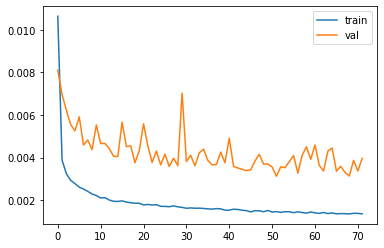

---Training time: 384.15509558 seconds ---


In [ ]:
# Load the pretrained model and re-fit
model = load_model('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/DD_Transfer_model_70_10_20.h5')

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  #Saves best model so far
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

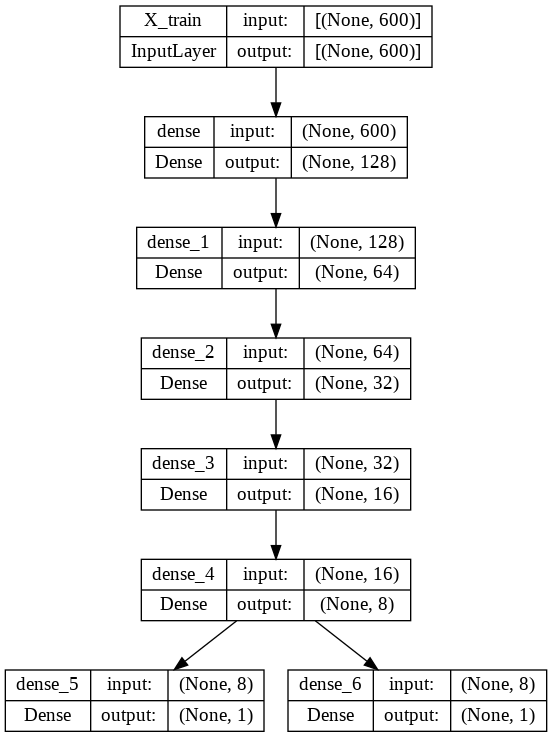

In [ ]:
# Model Summary
print(model.summary())
plot_model(model, show_shapes=True)

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.94539, Train (V) - 0.88796
R2 scores: Validation (SS) - 0.91385, Validation (V) - 0.89879
R2 scores: Testing (SS) - 0.81595, Testing (V) - 0.72531
RMSE scores: Train (SS) - 0.03481, Train (V) - 0.01819
RMSE scores: Validation (SS) - 0.05829, Validation (V) - 0.02367
RMSE scores: Testing (SS) - 0.09235, Testing (V) - 0.04470


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

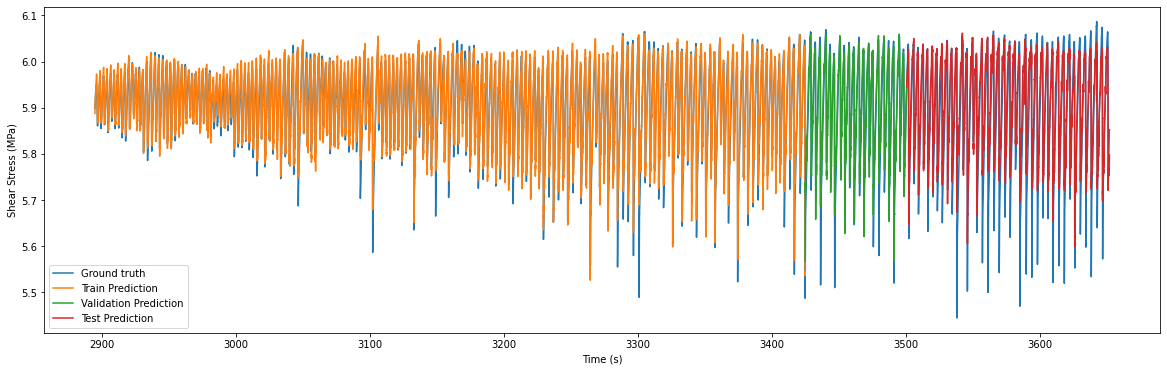

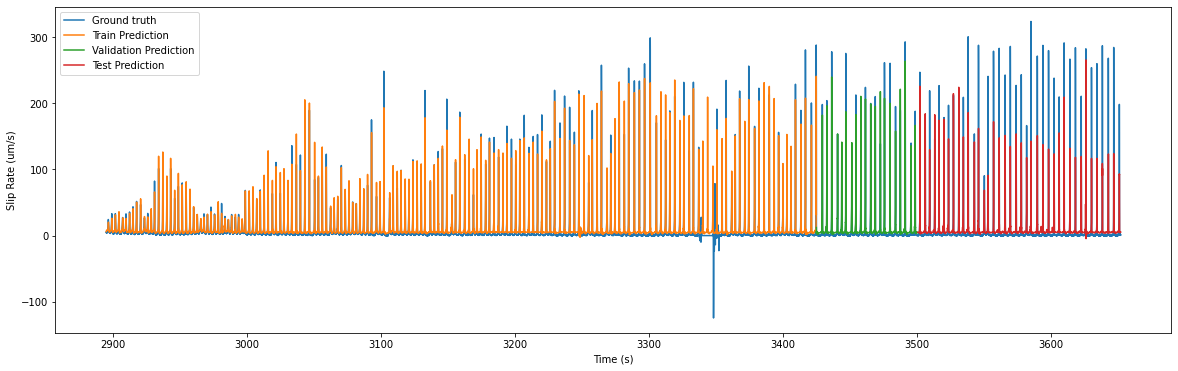

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

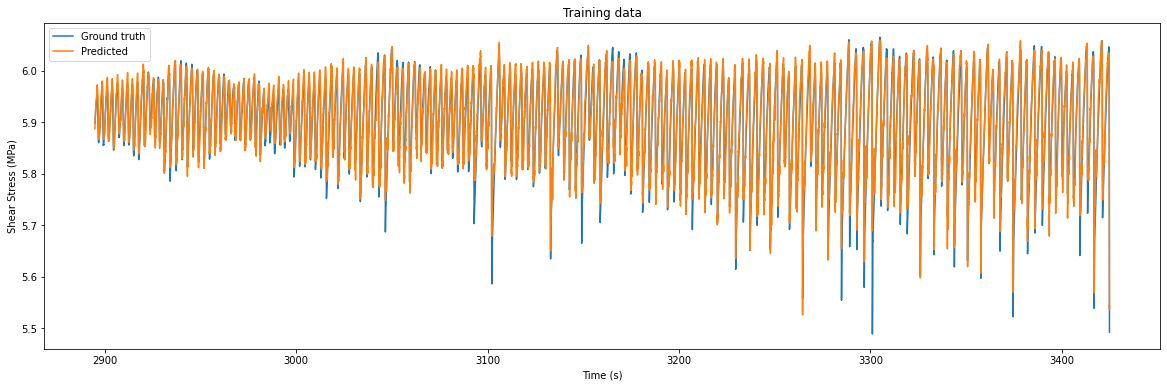

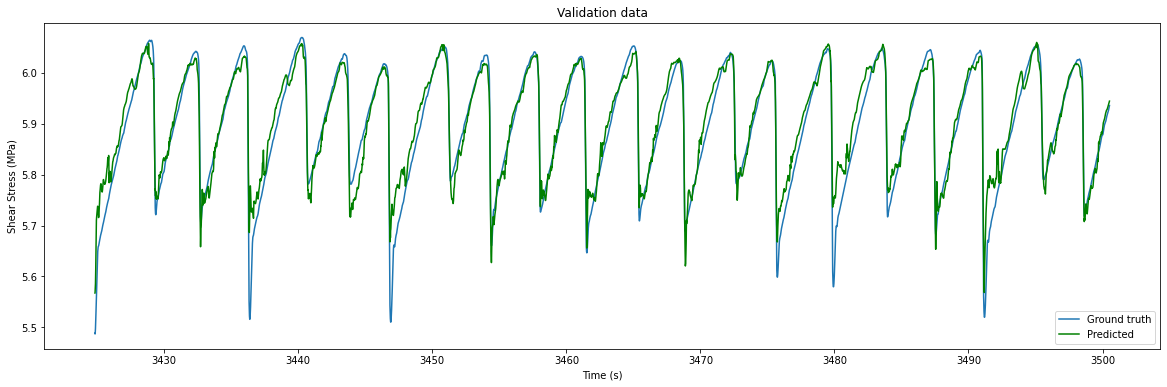

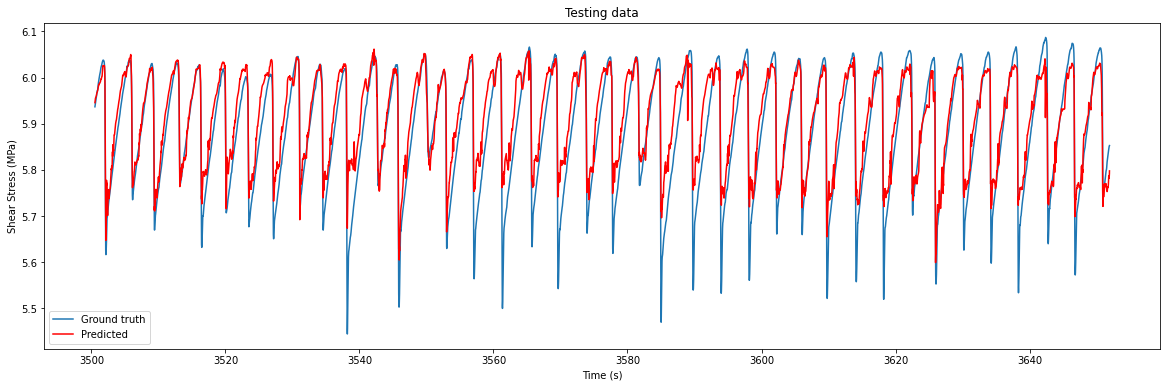

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

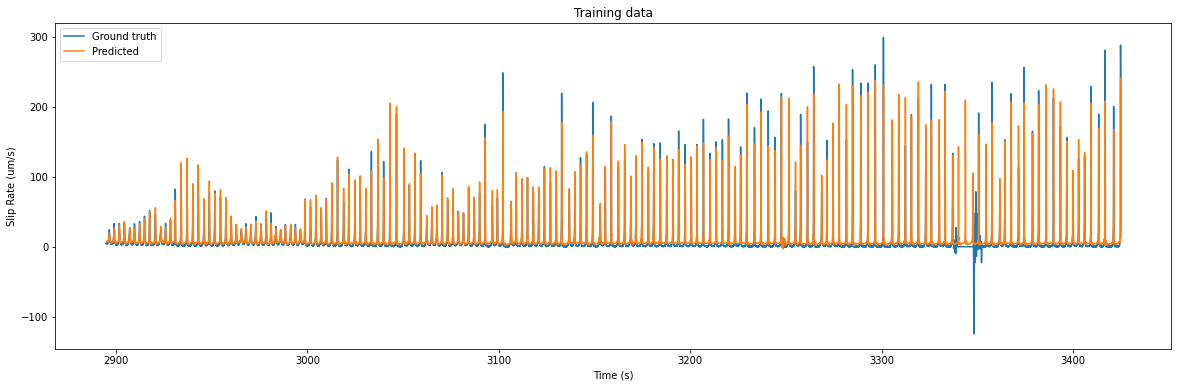

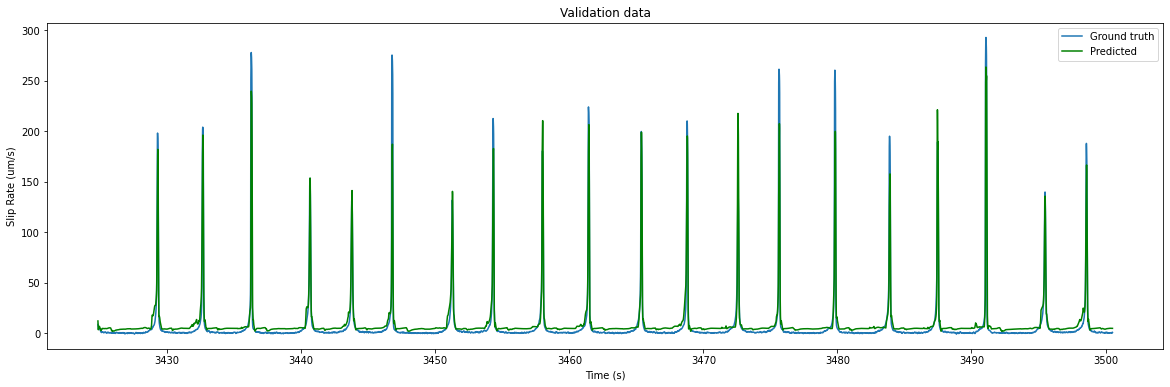

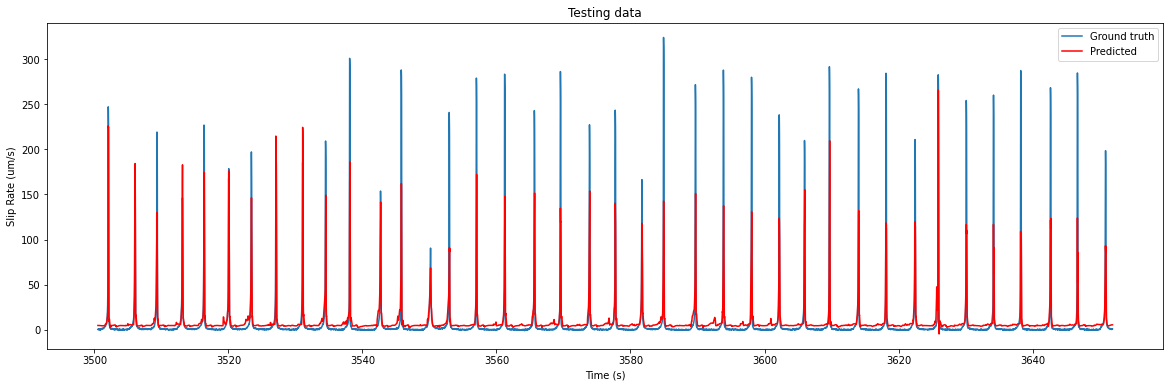

In [ ]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')